# Assignment 03 - Auto-encoders and The U-net Model

This assignment is composed of two tasks:

1. Design an auto-encoder to denoise a simple image dataset composed of circles;

2. Implement the U-net model for signal denoising;

Each task corresponds to 50% of the final grade of the assignment. Teams with less than 4 people can choose to do just one of the tasks without any penalty. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. 
    - Name the notebook as enel645_assignment03_team_(team number).ipynb
2. The weights of your Auto-encoder and U-net models. 
    - Name the weights files as team_(team number)_autoencoder.h5 (task 01) and team_(team number)_unet.h5 (task 02)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page (two files if your team has less than 4 people)

You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code and your model explanation (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%

The data for this assignment can be downloaded here:
- [GDrive](https://drive.google.com/file/d/17XmiQ1lNOP28blGmTFv8Zf5cf08unGgV/view?usp=sharing)
- [OneDrive](https://uofc-my.sharepoint.com/:u:/g/personal/roberto_medeirosdeso_ucalgary_ca/EVe0Mh19GUBGp7qXOIaXRtIBYeJgBtBvc5ULFoT1svhudw?e=rVNREx) - Link expires March 8th, 2021. 

## 1. Denoising Auto-encoder

Develop an auto-encoders that receives as input a 96 x 96 noisy image with a circle of a radius R and outputs the corresponding denoised image. Make the dimensionality of your latent space as low as posisble without compromising the results of the denoised images.

- Justify the choice of your latent space dimension;
- The results will be assessed visually; 

In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from skimage import transform
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 1.1 Load data 

In [19]:
# Adapt the paths to your environment
X_train = np.load("C:\\Users\\oluwa\\OneDrive\\Desktop\\ENEL 645 (DATA MINING AND MACHINE LEARNING)\\Data-assignment03\\Data\\Assignment03\\AUTOENCODER\\train.npy")[:,:,:,np.newaxis]
X_val = np.load("C:\\Users\\oluwa\\OneDrive\\Desktop\\ENEL 645 (DATA MINING AND MACHINE LEARNING)\\Data-assignment03\\Data\\Assignment03\\AUTOENCODER\\val.npy")[:,:,:,np.newaxis]
X_test = np.load("C:\\Users\\oluwa\\OneDrive\\Desktop\\ENEL 645 (DATA MINING AND MACHINE LEARNING)\\Data-assignment03\\Data\\Assignment03\\AUTOENCODER\\test.npy")
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2000, 96, 96, 1)
(500, 96, 96, 1)
(20, 96, 96)


### 1.2. Explore your data 

In [20]:
# Use this space to explore you datasets
# Create additional cells as you see fit
print("\nTrain set")
print("Images: ",X_train.shape)
print("\nVal set")
print("Images: ",X_val.shape)
print("\nTest set")
print("Images: ",X_test.shape)


Train set
Images:  (2000, 96, 96, 1)

Val set
Images:  (500, 96, 96, 1)

Test set
Images:  (20, 96, 96)


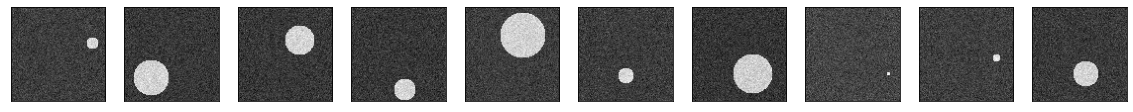

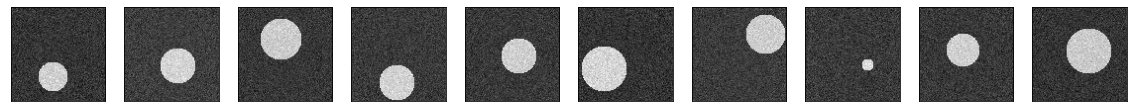

In [6]:
# Printing some images in the train set
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Printing some images in the validation set
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_val[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# displaying minimun, maximum, mean and std of training set
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

-0.5244176555743066 1.4873135181389396 0.06483575576181211 0.26572640224784966
-0.48315215630414876 1.444695593969531 0.06560921122081251 0.2668220989782381


### 1.3. Data scaling and Data augmentation

In [8]:
# Experiment with different data scaling methods

# Use data augmentation if you think it makes sense...
# Data Scaling
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

### 1.4. Define your  model, cost function, optimizer, learning rate

In [95]:
# Define your model here.

#Fully convolutional
# ishape=image shape, ndim=Latent space size, lr=learning rate
def my_autoencoder(ishape = (96,96,1),ndim = 10, lr = 1e-3):
    input_img = tf.keras.layers.Input(shape = ishape)
    c1 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(input_img)
    c2 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c1)
    c3 = tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c2)
    c4 = tf.keras.layers.Conv2D(1024, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(c3)
    flat = tf.keras.layers.Flatten()(c4)
    d1 = tf.keras.layers.Dense(ndim)(flat)
    encoder = tf.keras.models.Model(inputs = input_img, outputs = d1)
    input_decoder = tf.keras.layers.Input(shape = (ndim))
    d2 = tf.keras.layers.Dense(6*6*1024)(input_decoder)
    reshaped_img = tf.keras.layers.Reshape((6,6,1024))(d2)
    up1 = tf.keras.layers.UpSampling2D((2,2))(reshaped_img)
    c4 = tf.keras.layers.Conv2D(512, (3,3), activation = 'relu', padding = 'same')(up1)
    up2 = tf.keras.layers.UpSampling2D((2,2))(c4)
    c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same')(up2)
    up3 = tf.keras.layers.UpSampling2D((2,2))(c5)
    c6 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same')(up3)
    up4 = tf.keras.layers.UpSampling2D((2,2))(c6)
    c7 = tf.keras.layers.Conv2D(1, (3,3), activation = 'relu', padding = 'same')(up4)
    decoder = tf.keras.models.Model(inputs = input_decoder , outputs = c7)
    autoencoder = tf.keras.models.Model(inputs = input_img, outputs = decoder(encoder(input_img)))
    autoencoder.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = "mse")
    return encoder,decoder,autoencoder

In [96]:
encoder,decoder,autoencoder = my_autoencoder(ndim = 10)
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 512)       1180160   
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 1024)        4719616   
_________________________________________________________________
flatten_13 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_103 (Dense)            (None, 10)                368

### 1.5. Define your callbacks (save your model, patience, etc.)

In [97]:
model_name_autoencoder = "team_16_autoencoder.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_autoencoder, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
# define your callbacks
# remember that you need to save the weights of your best model!

### 1.6. Train your model

In [102]:
# train your model - decide for how many epochs
autoencoder.fit(X_train,X_train,batch_size=64, epochs = 50, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,X_val))

Epoch 1/50
32/32 [==============================] - 155s 5s/step - loss: 0.0123 - val_loss: 0.0121
Epoch 2/50
32/32 [==============================] - 154s 5s/step - loss: 0.0118 - val_loss: 0.0119
Epoch 3/50
32/32 [==============================] - 156s 5s/step - loss: 0.0116 - val_loss: 0.0117
Epoch 4/50
32/32 [==============================] - 153s 5s/step - loss: 0.0116 - val_loss: 0.0117
Epoch 5/50
32/32 [==============================] - 154s 5s/step - loss: 0.0115 - val_loss: 0.0117
Epoch 6/50
32/32 [==============================] - 153s 5s/step - loss: 0.0114 - val_loss: 0.0116
Epoch 7/50
32/32 [==============================] - 153s 5s/step - loss: 0.0115 - val_loss: 0.0117
Epoch 8/50
32/32 [==============================] - 153s 5s/step - loss: 0.0120 - val_loss: 0.0121
Epoch 9/50
32/32 [==============================] - 153s 5s/step - loss: 0.0116 - val_loss: 0.0117
Epoch 10/50
32/32 [==============================] - 153s 5s/step - loss: 0.0115 - val_loss: 0.0114
Epoch 11/

In [103]:
autoencoder.load_weights(model_name_autoencoder)
metrics = autoencoder.evaluate(X_test,X_test)

1/1 [==============================] - 0s 338ms/step - loss: 0.0106


### 1.7. Test your model

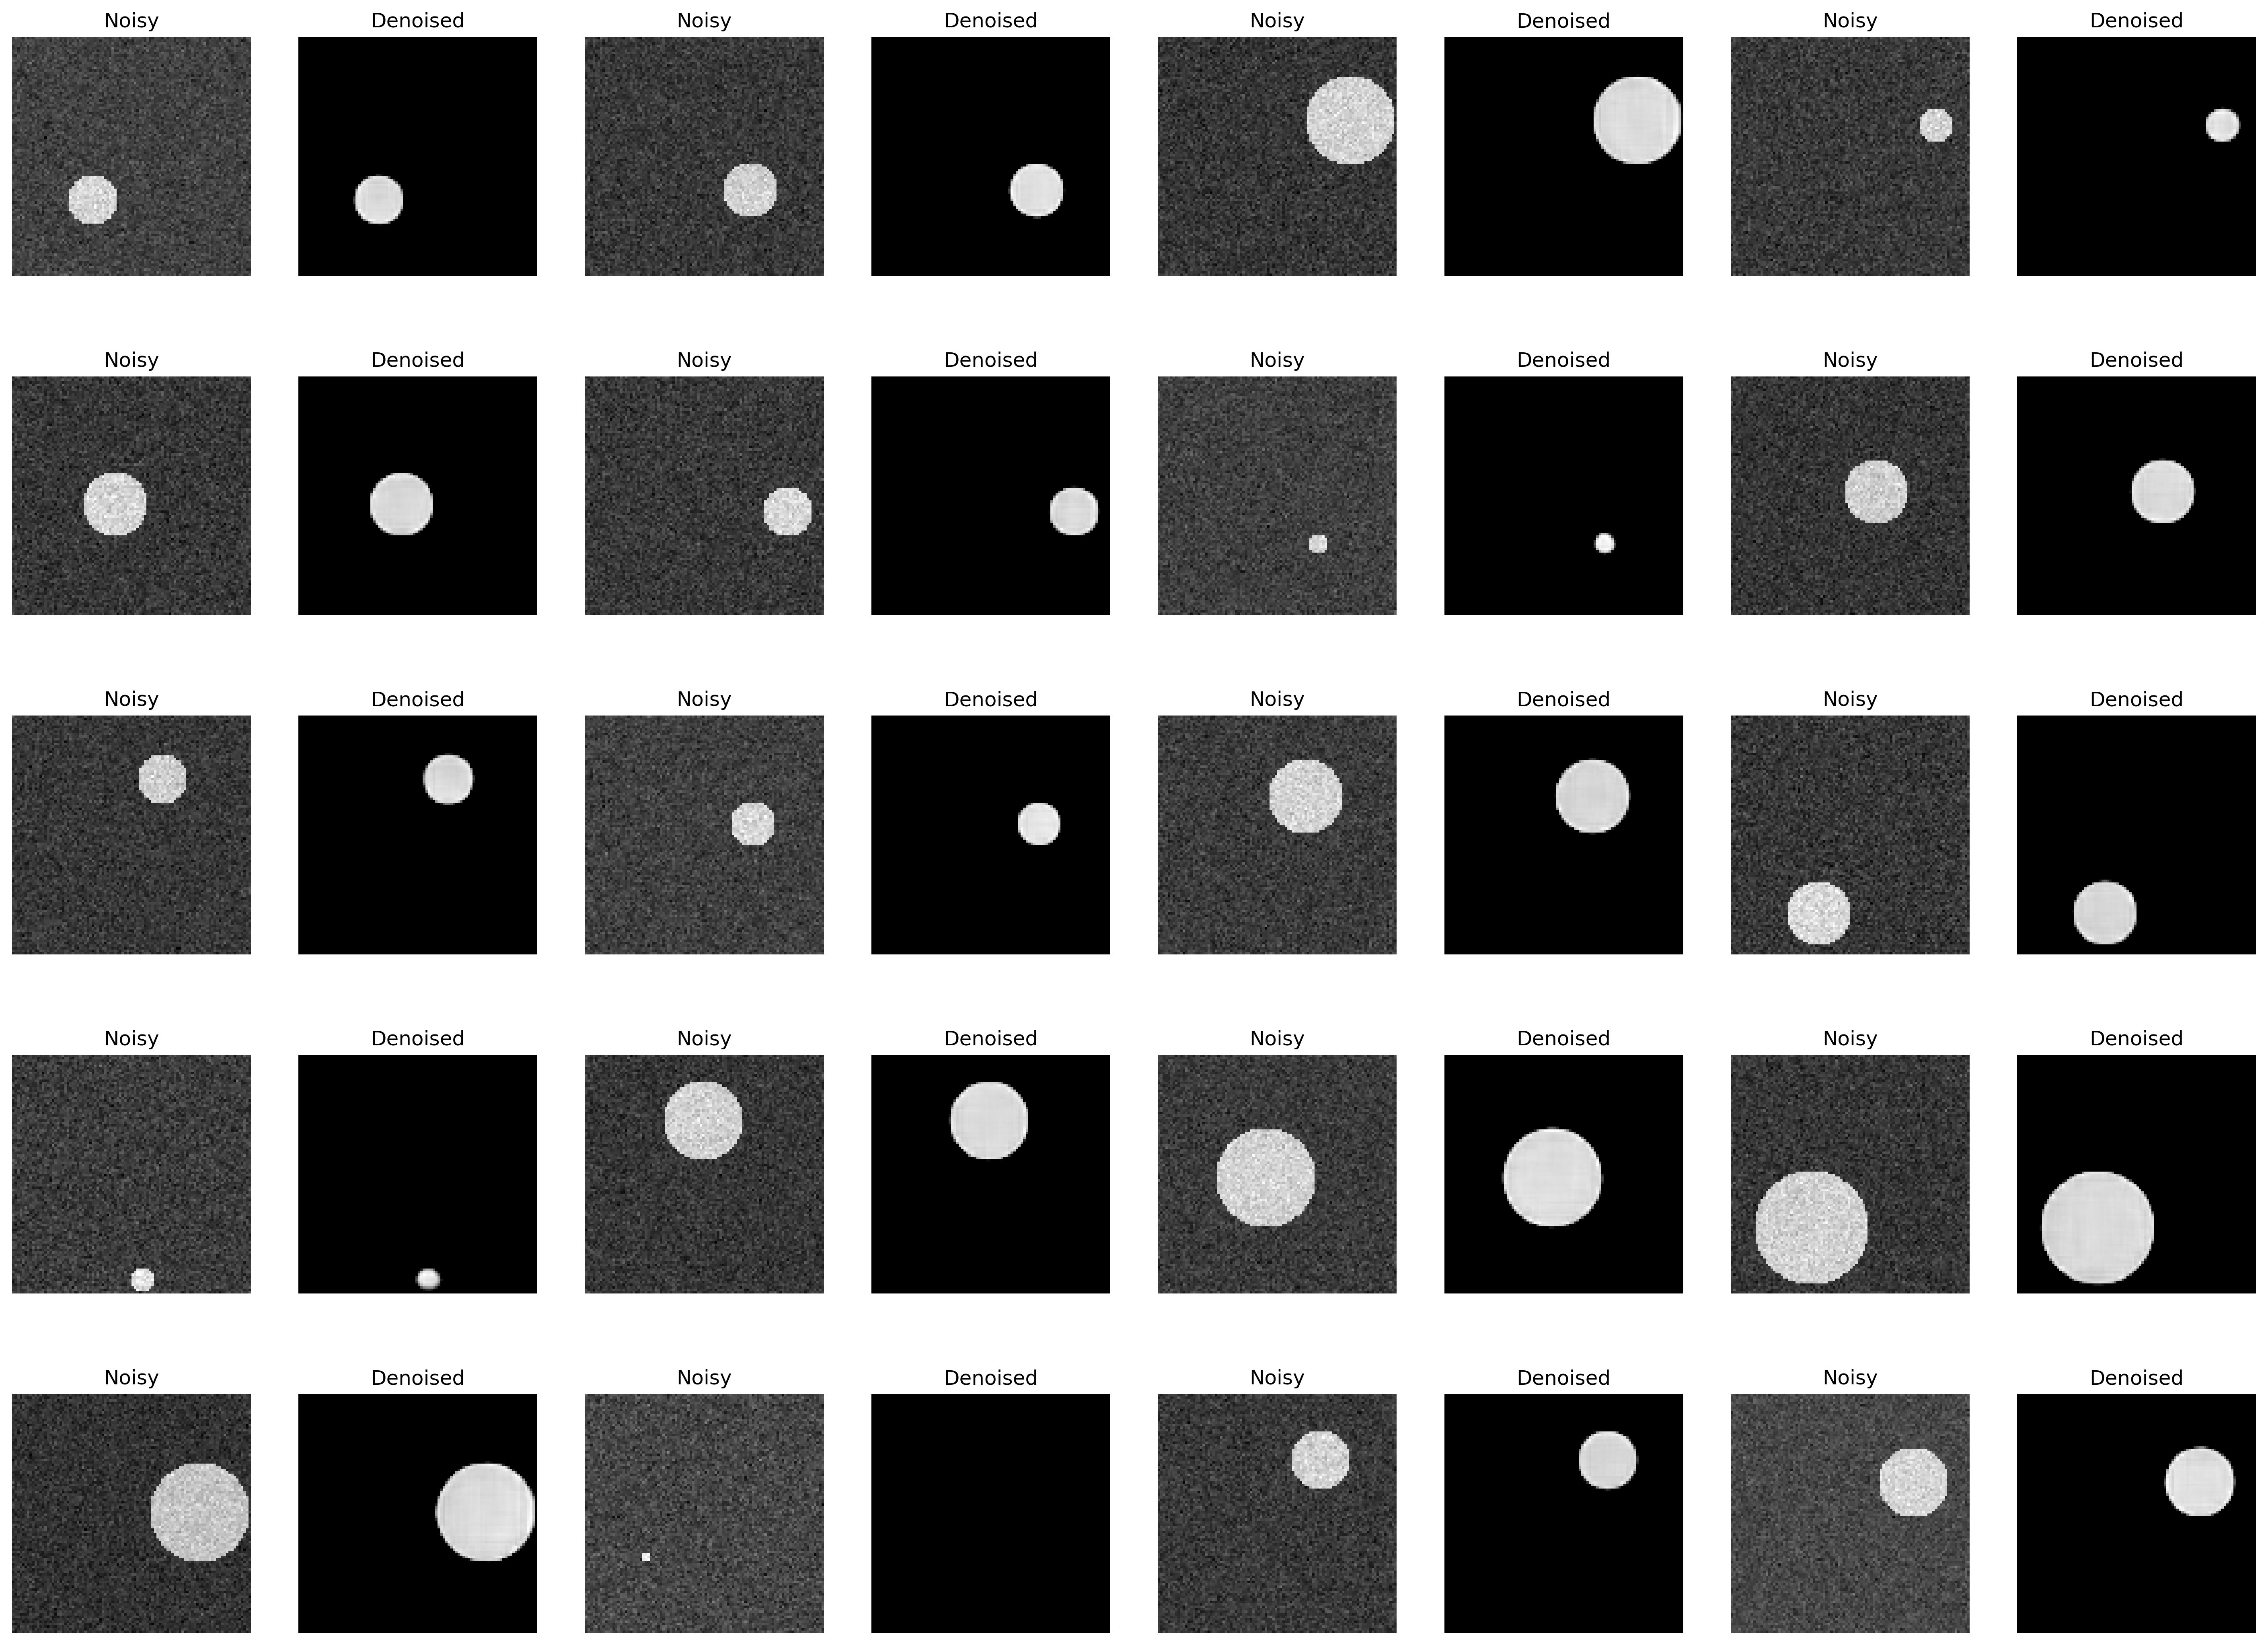

In [104]:
autoencoder.load_weights(model_name_autoencoder)
Xpred = autoencoder.predict(X_test)

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(20):
    plt.subplot(5,8,ii*2+1)
    plt.imshow(X_test[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Noisy")
    plt.subplot(5,8,ii*2 + 2)
    plt.imshow(Xpred[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Denoised")
plt.show()

## 2. Denoising U-net

Develop an U-net model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

The mean squared error (MSE) of your U-net model should be lower than the MSE of just averaging the noisy measurements. 

- The results will be assessed using mean squared error. 

### 2.1 Load data  and split into train, validation, test

In [2]:
# Printing the shapes of the input and labels of the train, test and validation sets
data = np.load("C:\\Users\\oluwa\\OneDrive\\Desktop\\ENEL 645 (DATA MINING AND MACHINE LEARNING)\\Data-assignment03\\Data\\Assignment03\\UNET\\noisy_transients.npy")
target = np.load("C:\\Users\\oluwa\\OneDrive\\Desktop\\ENEL 645 (DATA MINING AND MACHINE LEARNING)\\Data-assignment03\\Data\\Assignment03\\UNET\\reference.npy")
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]
X_train2 = data[:int(data.shape[0]*0.8)]
Y_train2 = target[:int(data.shape[0]*0.8)]

X_val2 = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val2 = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test2 = data[int(data.shape[0]*0.9):]
Y_test2 = target[int(data.shape[0]*0.9):]

print(X_train2.shape)
print(X_val2.shape)
print(X_test2.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [3]:
# Use this space to explore you datasets
# Create additional cells as you see fit
print("Train set")
print("Images: ",X_train2.shape)
print("Labels shape:",Y_train2.shape)
print("\nValidation set")
print("Images: ",X_val2.shape)
print("Labels shape:",Y_val2.shape)
print("\nTest set")
print("Images: ",X_test2.shape)
print("Labels shape: ",Y_test2.shape)

Train set
Images:  (216, 256, 20)
Labels shape: (216, 256)

Validation set
Images:  (27, 256, 20)
Labels shape: (27, 256)

Test set
Images:  (27, 256, 20)
Labels shape:  (27, 256)


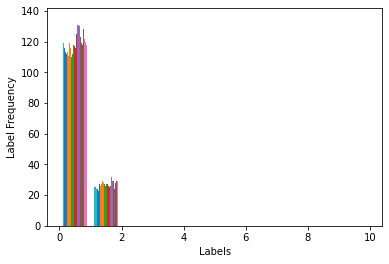

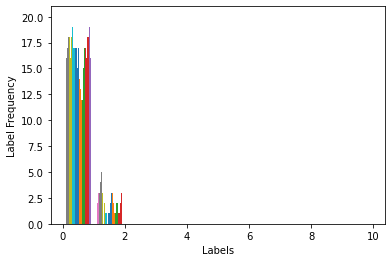

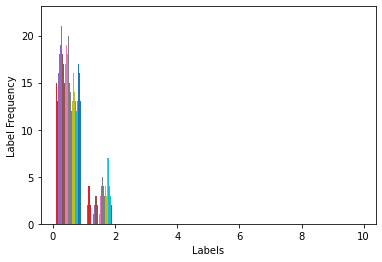

In [4]:
#Displaying Label vs label frequecy for train set
plt.figure()
plt.hist(Y_train2, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

#Displaying Label vs label frequecy for validation set
plt.figure()
plt.hist(Y_val2, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

#Displaying Label vs label frequecy for test set
plt.figure()
plt.hist(Y_test2, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

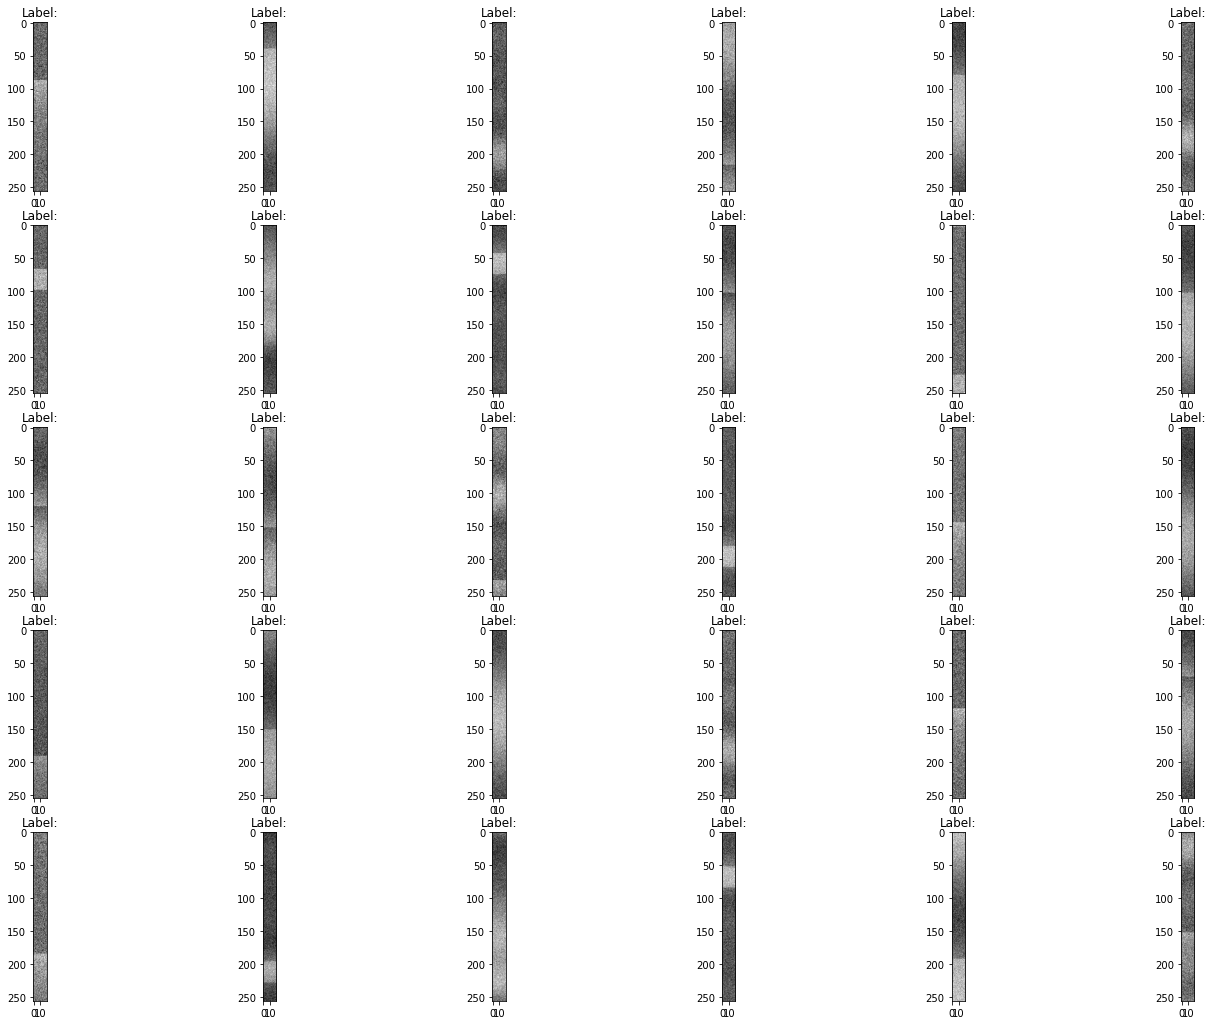

In [5]:
# Disaplying some samples from the training set
sample_indexes = np.random.choice(np.arange(X_train2.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train2[jj], cmap = "gray")
    plt.title("Label:" %Y_train2[jj])
plt.show()

In [6]:
# displaying minimun, maximum, mean and std of training set
print(X_train2.min(),X_train2.max(),X_train2.mean(),X_train2.std())
print(X_val2.min(),X_val2.max(),X_val2.mean(),X_val2.std())

-2.9169581831740183 3.7456143553633217 0.20913680209980937 0.7302193378862896
-2.508945979141302 3.4599287898217423 0.16601065777920837 0.68656671154293


### 2.3. Data scaling and Data augmentation

In [7]:
# Experiment with different data scaling methods

# Use data augmentation if you think it makes sense...
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train2 = X_train2/255
    X_val2 = X_val2/255
    X_test2 = X_test2/255
elif norm_type == 1:
    train_mean, train_std = X_train2.mean(),X_train2.std() 
    X_train2 = (X_train2 - train_mean)/train_std
    X_val2 = (X_val2 - train_mean)/train_std
    X_test2 = (X_test2 - train_mean)/train_std
else:
    pass

### 2.4. Define your  model, cost function, optimizer, learning rate

In [8]:
# Define your model here. 
# ishape = input image shape, lr = learning rate
def my_unet(ishape = (256,20),lr = 1e-3,learning_decay = 1e-6, drop_out = 0.1,nchannels = 1,kshape = (3,3)):
    
    dropout = drop_out
    
    input_img = tf.keras.layers.Input((ishape[0], ishape[1],nchannels))
    
    conv1 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(input_img)
    conv1 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(dropout)(pool2)

    conv3 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(192, kshape, activation='relu', padding='same')(conv3)

    up4= tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv3), conv2],axis=-1)
    up4= tf.keras.layers.Dropout(dropout)(up4)
    conv5= tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(up4)
    conv5= tf.keras.layers.Conv2D(96, kshape, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv5), conv1], axis=-1)
    up6 = tf.keras.layers.Dropout(dropout)(up6)
    conv7 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(up6)
    conv7 = tf.keras.layers.Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(conv7)
    out = tf.keras.layers.Add()([conv8, input_img]) #Residual connection
    model = tf.keras.models.Model(inputs=input_img, outputs=out)
    opt = tf.keras.optimizers.Adam(lr, decay = learning_decay)
    model.compile(optimizer= opt,loss='mse')
    return model

In [9]:
model = my_unet()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 20, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 20, 48)  480         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 20, 48)  20784       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 10, 48)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 2.5. Define your callbacks (save your model, patience, etc.)

In [10]:
model_name_unet = "team_16_unet.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_unet, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

### 2.6. Train your model

In [11]:
# train your model - decide for how many epochs
history = model.fit(X_train2, Y_train2[:,:,np.newaxis], validation_data = (X_val2, Y_val2[:,:,np.newaxis]),\
                    epochs=100,verbose=1, callbacks = [early_stop, monitor, lr_schedule])

Epoch 1/100
7/7 [==============================] - 12s 2s/step - loss: 0.3755 - val_loss: 0.3392
Epoch 2/100
7/7 [==============================] - 10s 1s/step - loss: 0.3514 - val_loss: 0.2715
Epoch 3/100
7/7 [==============================] - 10s 1s/step - loss: 0.3179 - val_loss: 0.1294
Epoch 4/100
7/7 [==============================] - 10s 1s/step - loss: 0.2107 - val_loss: 0.1740
Epoch 5/100
7/7 [==============================] - 10s 1s/step - loss: 0.1649 - val_loss: 0.1210
Epoch 6/100
7/7 [==============================] - 10s 1s/step - loss: 0.1292 - val_loss: 0.0891
Epoch 7/100
7/7 [==============================] - 10s 1s/step - loss: 0.1166 - val_loss: 0.0733
Epoch 8/100
7/7 [==============================] - 10s 1s/step - loss: 0.0829 - val_loss: 0.0455
Epoch 9/100
7/7 [==============================] - 10s 1s/step - loss: 0.0410 - val_loss: 0.0239
Epoch 10/100
7/7 [==============================] - 10s 1s/step - loss: 0.0239 - val_loss: 0.0163
Epoch 11/100
7/7 [===========

### 2.7. Test your model

Unet MSE:
0.0044987566440663354
Mean MSE:
0.00929520931744572


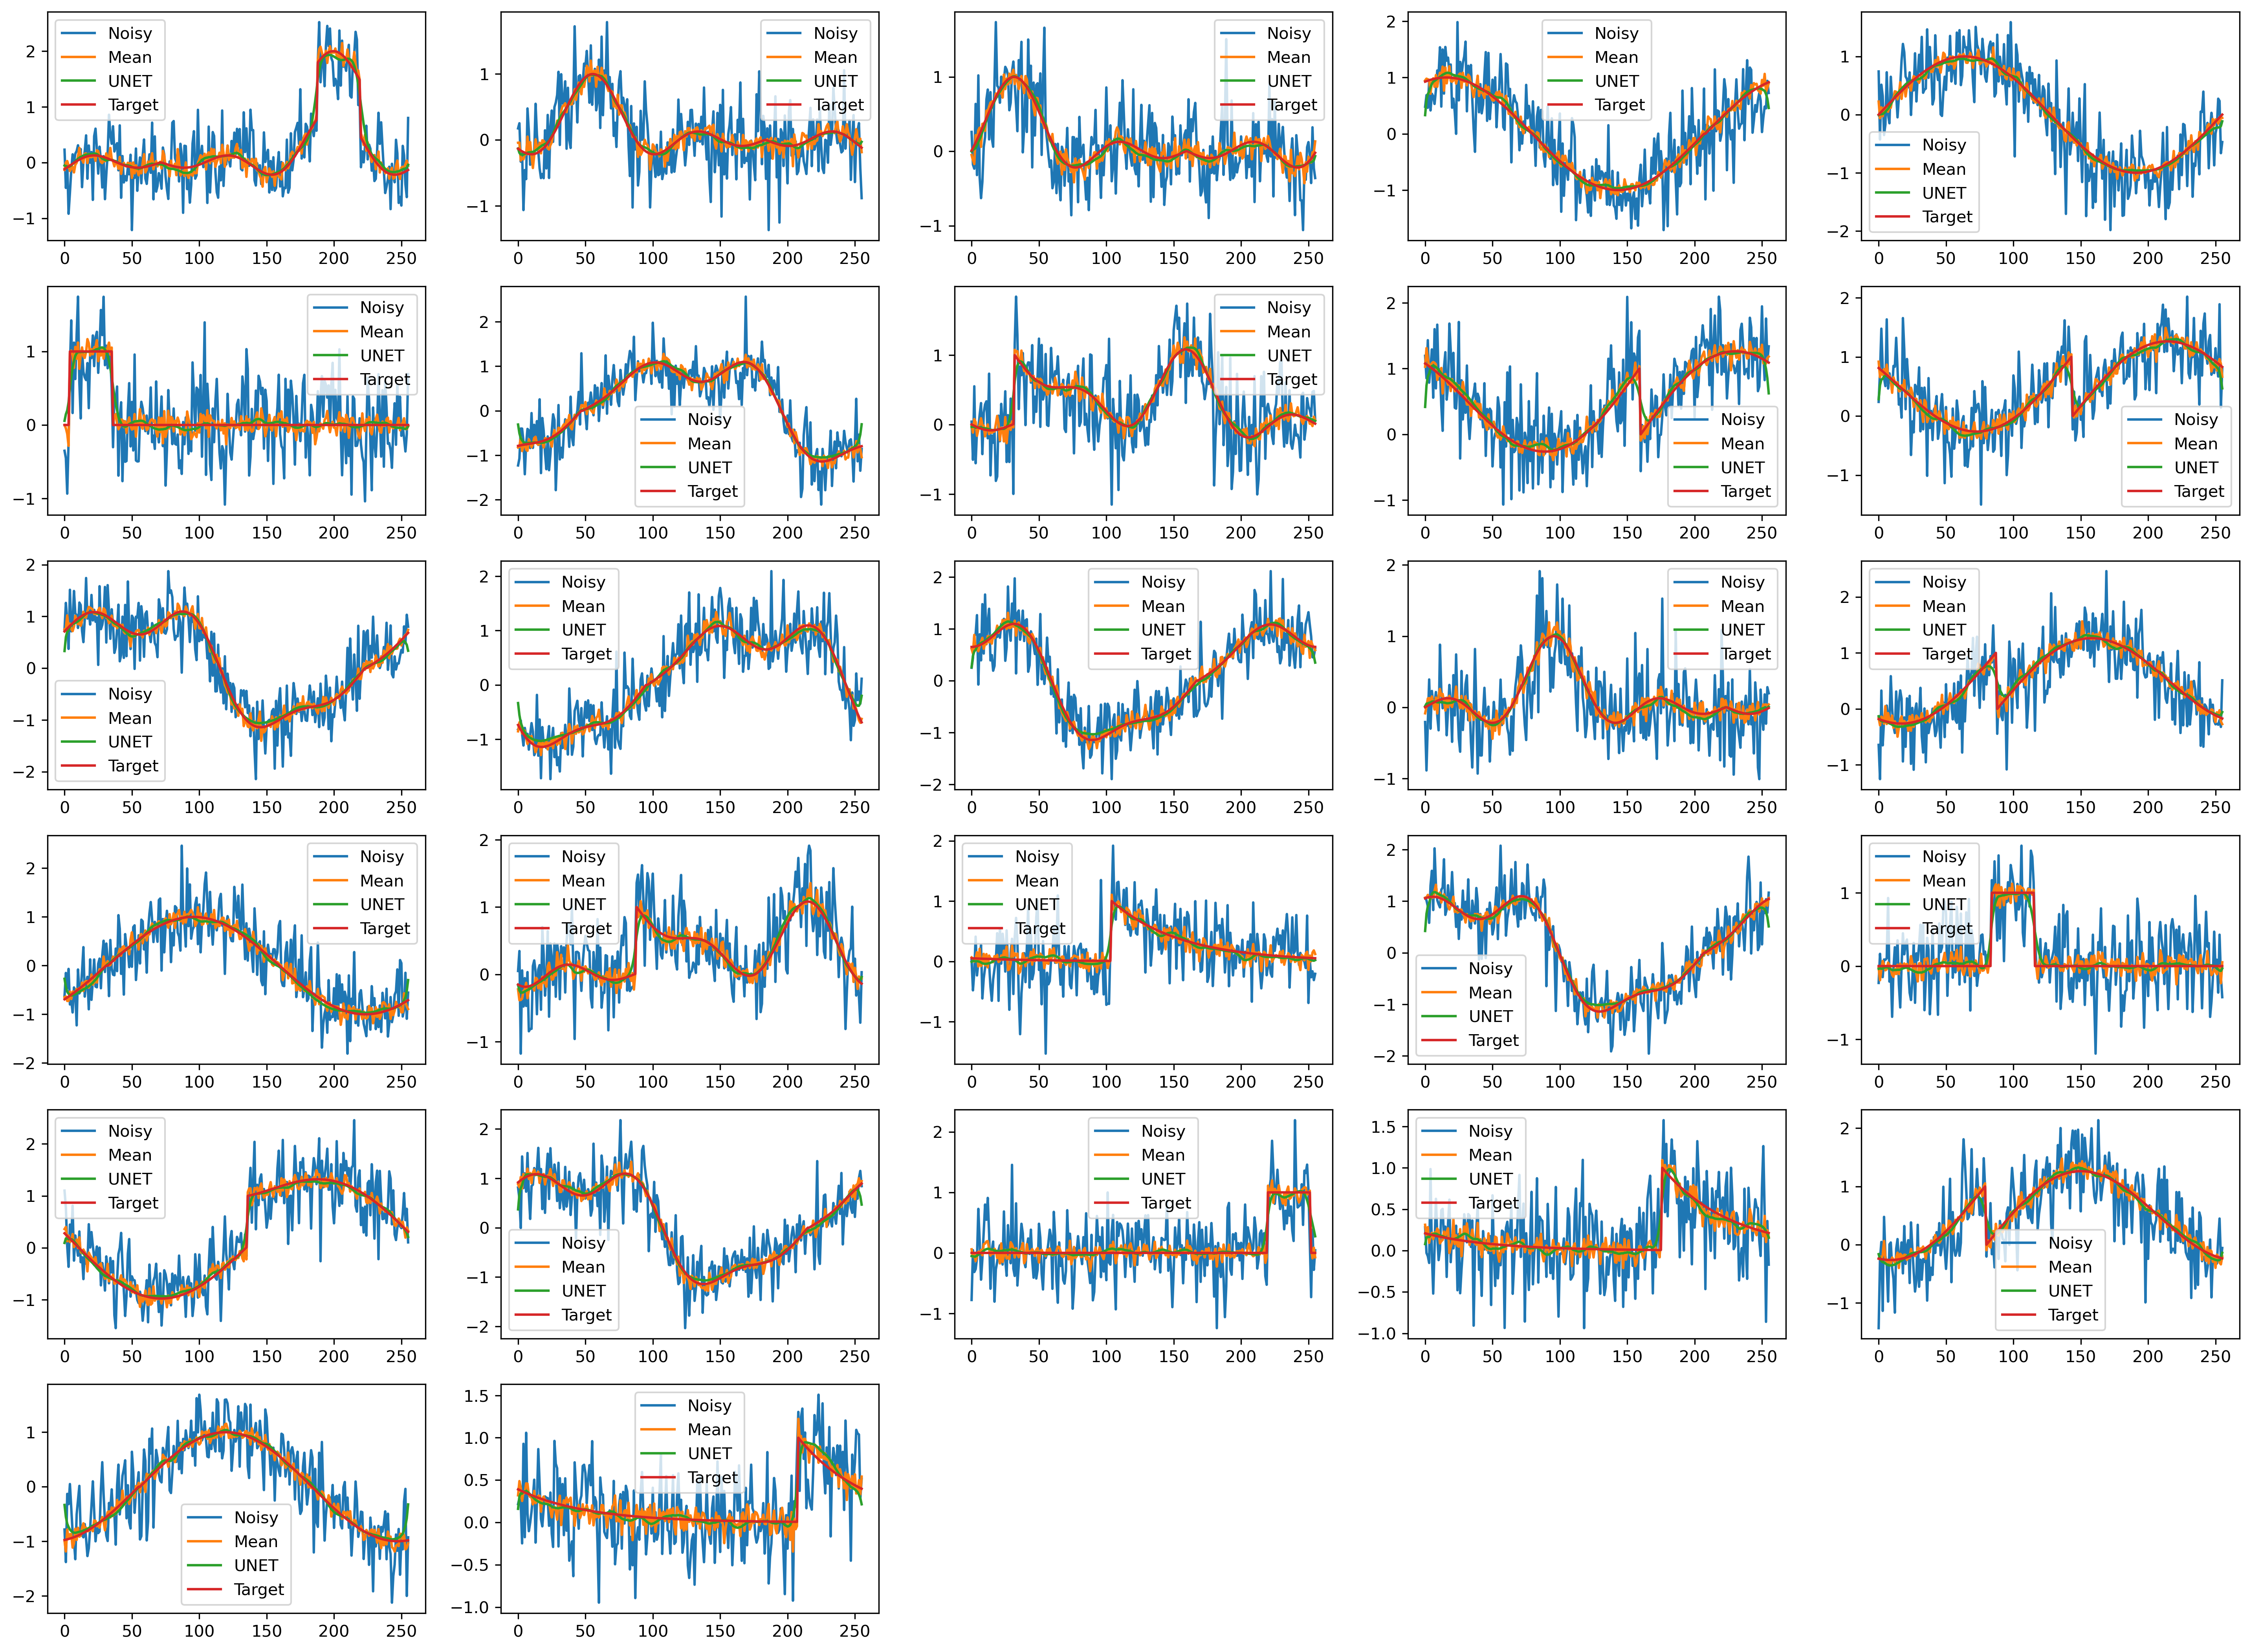

In [12]:
# Remember to "unscale your data".
import numpy as np
model.load_weights(model_name_unet)
Ypred = model.predict(X_test2)[:,:,0]

#Unscaling our data
X_test_unscaled = X_test2 * 255  
Ymean = X_test_unscaled.mean(axis=-1)


Ypred = Ypred[:,:,0]


print("Unet MSE:")
print(((Ypred - Y_test2)**2).mean())
print("Mean MSE:")
print(((Ymean - Y_test2)**2).mean())


#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    plt.plot(X_test_unscaled[ii,:,0], label = "Noisy")
    plt.plot(Ymean[ii], label = "Mean")
    plt.plot(Ypred[ii], label = "UNET")
    plt.plot(Y_test2[ii], label = "Target")
    plt.legend()
plt.show()